In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import matplotlib.patches as mpatches
import os
import math
import random
from scipy.stats import ranksums
from scipy.stats import chi2_contingency

In [2]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

In [3]:
#modified is the normal gtf without the first two lines below
# stringtie --merge 60541_transcripts.gtf 60542_transcripts.gtf 60543_transcripts.gtf 60544_transcripts.gtf 60545_transcripts.gtf 60546_transcripts.gtf 60547_transcripts.gtf 60548_transcripts.gtf -o afran_genome_annotation_0.5.gtf -F 0 -T 0.5
# StringTie version 2.2.1
fran_gtf=pd.read_csv("/nfs/scistore18/vicosgrp/melkrewi/Project_snRNA_ovaries_with_W/1.stringtie/afran_genome_annotation_0.5_2_modified.gtf",sep="\t",header=None)
fran_gtf_2=fran_gtf[[0,2,3,8]]
fran_gtf_2=fran_gtf_2[fran_gtf_2[2]=='transcript']
fran_gtf_2['gene_id']=fran_gtf_2[8].str.split(';',expand=True)[0]
fran_gtf_2=fran_gtf_2[[0,2,3,'gene_id']].drop_duplicates(subset='gene_id', keep="first")
fran_gtf_2['gene_id']=fran_gtf_2['gene_id'].str[9:-1]

In [5]:
seurat_clusters=pd.read_csv("/nfs/scistore18/vicosgrp/melkrewi/Project_snRNA_ovaries_with_W/6.Integration/clean_run_04_12_2023/round_2/seurat_clusters_cells_integrated_DUBStepR_3_2.txt",sep=",")

In [6]:
normalized_exp=pd.read_csv("/nfs/scistore18/vicosgrp/melkrewi/Project_snRNA_ovaries_with_W/6.Integration/clean_run_04_12_2023/round_2/same_analysis_no_ambient/counts_DUBStepR_3_2_no_ambient_removal.csv",sep=",",low_memory=False)

In [7]:
merged_normalized=pd.merge(normalized_exp,fran_gtf_2,left_on='gene',right_on='gene_id')

In [8]:
del normalized_exp

In [9]:
W_scaffolds=['scaffold000049W',
'scaffold000218W',
'scaffold000121W',
'scaffold000336W',
'scaffold000179W',
'scaffold000243W',
'scaffold000334W',
'scaffold000030W',
'scaffold000094W',
'scaffold000085W',
'scaffold000133W',
'scaffold000315W',
'scaffold000444W',
'scaffold000018W',
'scaffold000222W',
'scaffold000265W',
'scaffold000119W',
'scaffold000294W',
'scaffold000196W',
'scaffold000043W',
'scaffold000136W',
'scaffold000131W',
'scaffold000032W',
'scaffold000274W',
'scaffold000023W',
'scaffold000046W',
'scaffold000324W',
'scaffold000330W',
'scaffold000370W',
'scaffold000183W',
'scaffold000141W',
'scaffold000272W',
'scaffold000232W',
'scaffold000031W',
'scaffold000132W',
'scaffold000116W',
'scaffold000152W',
'scaffold000068W']

In [10]:
merged_all_norm=merged_normalized[merged_normalized[0].str.contains('chr')|merged_normalized[0].isin(W_scaffolds)]

In [12]:
def windows_and_strata(df2,seurat_clusters):
    df=df2.copy()
    df.loc[
      ((df[0]!='chr6')&(~df[0].str.contains('W'))), 
      'strata'
    ] = 'Autosomal'
    df.loc[
      ((df[0]=='chr6')&(df[3]<=45665001)), 
      'strata'
    ] = 'pseudo'
    df.loc[
      ((df[0]=='chr6')&(((df[3] > 45665001.0) & (df[3] <= 48665001))))
    , 
      'strata'
    ] = 'S1'
    df.loc[
      ((df[0]=='chr6')&(((df[3] > 48665001) & (df[3] <= 53325001))|((df[3] > 53585001) & (df[3] <= 54575001))|((df[3] > 54735001) & (df[3] <= 61725001))))
    , 
      'strata'
    ] = 'S0'
    df.loc[
      ((df[0]=='chr6')&(((df[3] > 61725001.0) & (df[3] <= 66725001))))
    , 
      'strata'
    ] = 'S2'
    df.loc[
      ((df[0].str.contains('W'))), 
      'strata'
    ] = 'W'
    #for j in [1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]:
    #    for i in np.arange(0,math.floor(len(df[df[0]=='chr'+str(j)])/len(df[df['strata'+str(strata)]==str(strata)])),1):
    #        df.loc[df['gene'].isin(df[df[0]=='chr'+str(j)][i*len(df[df['strata'+str(strata)]==str(strata)]):(i*len(df[df['strata'+str(strata)]==str(strata)])+len(df[df['strata'+str(strata)]==str(strata)]))]['gene'].tolist()), 'strata' +str(strata)] = 'chr'+str(j)+'bin' +str(i)
    return df

In [13]:
S0_pre_results=windows_and_strata(merged_all_norm,seurat_clusters)
df_2=S0_pre_results.drop([0,2,3,'gene','gene_id'],axis=1).groupby(["strata"]).mean().T.reset_index()
df_3=pd.merge(seurat_clusters,df_2,left_on='barcodes',right_on='index')
#for i in columns:
df_3['S0/Auto']=df_3['S0']/df_3['Autosomal']
df_3['S0/Auto']=df_3['S0/Auto']+(1-df_3[df_3['seurat_clusters'].isin([2,0,4])]['S0/Auto'].median())#-df_3[df_3['seurat_clusters'].isin([2,0,4])]['S0/Auto'].mean()

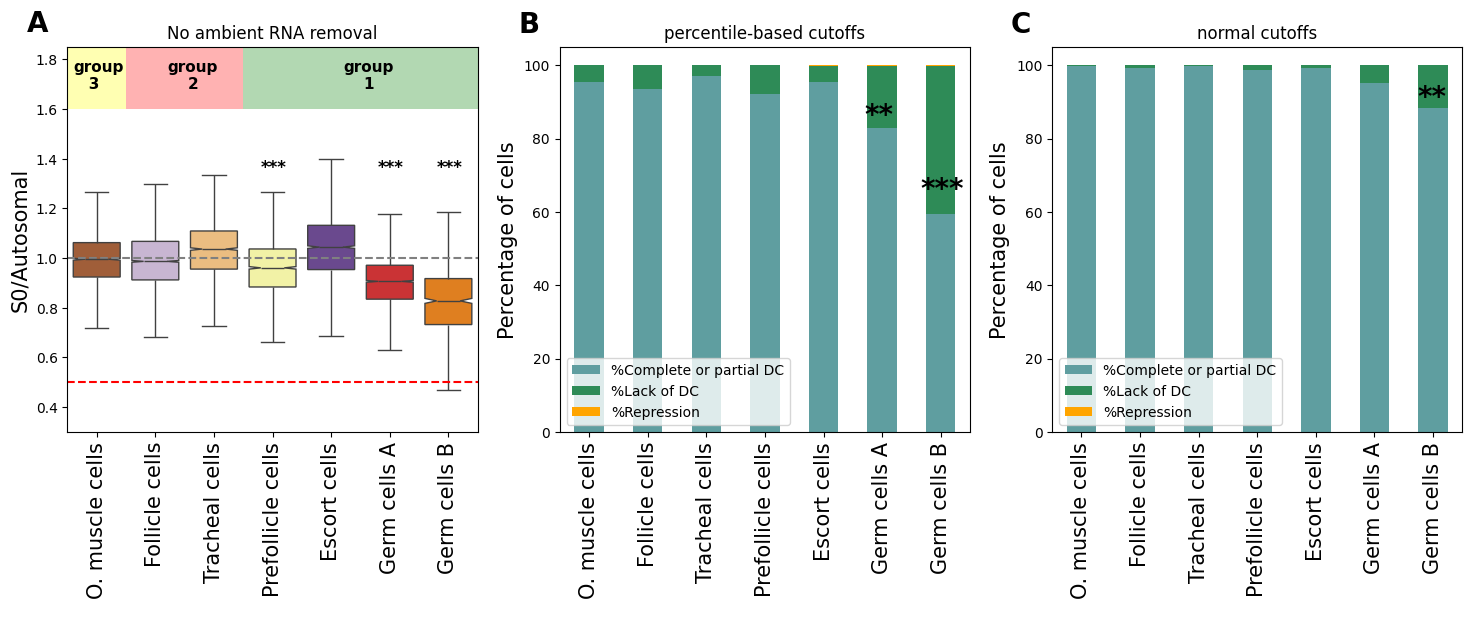

In [110]:
S0_results=df_3
#plt.figure(figsize=(10, 5))
#plt.subplot(2,1,0)
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(18, 5))
#my_pal ={'0':'#cab2d6','1':'#e31a1c','2':'#b15928','3':'#6a3d9a','4':'#fdbf6f','5':'#ffff99','6':'#ff7f00'}
my_pal ={0:'#cab2d6',1:'#e31a1c',2:'#b15928',3:'#6a3d9a',4:'#fdbf6f',5:'#ffff99',6:'#ff7f00'}

#sns.boxplot(x='seurat_clusters', y='S0/Auto', data=S0_results,showfliers=False,order=[2,0,4,5,3,1,6],palette=my_pal,ax=axes[0],notch=True)
sns.boxplot(x='seurat_clusters', y='S0/Auto', data=S0_results,showfliers=False,order=[2,0,4,5,3,1,6],hue='seurat_clusters',palette=my_pal,ax=axes[0],notch=True,legend=False)
axes[0].hlines(1,-0.5,6.5,color="gray",linestyle='dashed')
axes[0].hlines(0.5,-0.5,6.5,color="red",linestyle='dashed')
#axes[0].hlines(np.median(S0_results[S0_results['seurat_clusters'].isin([2,0,4])]['mean_all_rows'])+1,-0.5,6.5,color="red",linestyle='dashed')
#axes[0].vlines(0.5,-3.6,3,color="black",linewidth=1)
#axes[0].vlines(2.5,-3.6,3,color="black",linewidth=1)
axes[0].text(4.2, 1.8, 'group\n    1',fontsize=11, fontweight='bold', va='top')
axes[0].text(-1.2, 2, 'A',fontsize=20, fontweight='bold', va='top')
axes[0].text(1.2, 1.8, 'group\n    2',fontsize=11, fontweight='bold', va='top')
axes[0].text(-0.4, 1.8, 'group\n   3',fontsize=11,fontweight='bold', va='top')
axes[0].set_ylim(ymax=1.85,ymin=0.3)
axes[0].set_xlim(xmax=6.5,xmin=-0.5)
axes[0].fill_between([2.5,6.5], 1.6, 1.85,facecolor='green', alpha=0.3,zorder=0)
axes[0].fill_between([0.5,2.5], 1.6, 1.85,facecolor='red', alpha=0.3,zorder=0)
axes[0].fill_between([-0.5,0.5],1.6, 1.85,facecolor='yellow', alpha=0.3,zorder=0)
axes[0].set_ylabel('S0/Autosomal',fontsize=15)
axes[0].set_xlabel(' ')
axes[0].text(2.8, 1.4, convert_pvalue_to_asterisks(ranksums(S0_results[S0_results['seurat_clusters'].isin([5])]['S0/Auto'],S0_results[S0_results['seurat_clusters'].isin([2,0,4])]['S0/Auto'],alternative='less').pvalue),fontsize=12, fontweight='bold', va='top')
axes[0].text(4.8, 1.4, convert_pvalue_to_asterisks(ranksums(S0_results[S0_results['seurat_clusters'].isin([1])]['S0/Auto'],S0_results[S0_results['seurat_clusters'].isin([2,0,4])]['S0/Auto'],alternative='less').pvalue),fontsize=12, fontweight='bold', va='top')
axes[0].text(5.8, 1.4, convert_pvalue_to_asterisks(ranksums(S0_results[S0_results['seurat_clusters'].isin([6])]['S0/Auto'],S0_results[S0_results['seurat_clusters'].isin([2,0,4])]['S0/Auto'],alternative='less').pvalue),fontsize=12, fontweight='bold', va='top')
region = ['O. muscle cells','Follicle cells','Tracheal cells','Prefollicle cells','Escort cells','Germ cells A','Germ cells B']
axes[0].set_xticks(np.arange(0,7), region,rotation = 90,fontsize=15)
axes[0].set_title("No ambient RNA removal")
##panel 2
exp=S0_results
exp['mean_all_rows']=exp['S0/Auto']
exp.loc[
  (exp['mean_all_rows']>np.percentile(S0_results[S0_results['seurat_clusters'].isin([2,0,4])]['mean_all_rows'],5)), 
  'zone'
] = 'DC'
exp.loc[
  (exp['mean_all_rows']<=np.percentile(S0_results[S0_results['seurat_clusters'].isin([2,0,4])]['mean_all_rows'],5))&(exp['mean_all_rows']>np.percentile(S0_results[S0_results['seurat_clusters'].isin([2,0,4])]['mean_all_rows'],5)*0.5), 
  'zone'
] = 'Lack of DC'
exp.loc[
  (exp['mean_all_rows']<=np.percentile(S0_results[S0_results['seurat_clusters'].isin([2,0,4])]['mean_all_rows'],5)*0.5), 
  'zone'
] = 'Repression'
Zones_1=pd.DataFrame(exp.groupby('seurat_clusters')['zone'].value_counts()).unstack(fill_value=0).reset_index(drop=True).reset_index(drop=True)
Zones_1.columns = Zones_1.columns.droplevel()
Zones_1=Zones_1.reset_index()
Zones_1['%Complete or partial DC']=(Zones_1['DC']/(Zones_1['DC']+Zones_1['Repression']+Zones_1['Lack of DC']))*100
Zones_1['%Repression']=(Zones_1['Repression']/(Zones_1['DC']+Zones_1['Repression']+Zones_1['Lack of DC']))*100
Zones_1['%Lack of DC']=(Zones_1['Lack of DC']/(Zones_1['DC']+Zones_1['Repression']+Zones_1['Lack of DC']))*100
exp_plot=Zones_1[["%Complete or partial DC","%Lack of DC","%Repression"]].reindex([2,0,4,5,3,1,6]).plot.bar(stacked=True,color=['cadetblue','seagreen',"orange"],ax=axes[1])
exp_plot.legend(loc=3) 
axes[1].text(-1.2, 115, 'B',fontsize=20, fontweight='bold', va='top')
axes[1].set_ylabel("Percentage of cells",fontsize=15)
axes[1].set_xlabel(' ')
Zones_1_stats=Zones_1[["%Complete or partial DC","%Lack of DC","%Repression"]].reindex([2,0,4,5,3,1,6]).T.reset_index()#[[2,1]]
#Zones_1_stats['somatic']=np.median([Zones_1_stats[2].astype(float),Zones_1_stats[0].astype(float),Zones_1_stats[4].astype(float)])
Zones_1_stats['somatic']=Zones_1_stats[[2,0,4]].median(axis=1)
Zones_1_stats=Zones_1_stats.drop([2,0,4],axis=1)
Zones_1_stats.loc[len(Zones_1_stats.index)] = np.append(np.array(['%Not_repressed']),np.array(Zones_1_stats[Zones_1_stats['zone']=='%Lack of DC'][[5,3,1,6,'somatic']].astype(float))+np.array(Zones_1_stats[Zones_1_stats['zone']=='%Complete or partial DC'][[5,3,1,6,'somatic']].astype(float)))#].insert(0, 'NI')
Zones_1_stats.loc[len(Zones_1_stats.index)] = np.append(np.array(['%No_Lack_of_DC']),np.array(Zones_1_stats[Zones_1_stats['zone']=='%Repression'][[5,3,1,6,'somatic']].astype(float))+np.array(Zones_1_stats[Zones_1_stats['zone']=='%Complete or partial DC'][[5,3,1,6,'somatic']].astype(float)))#].insert(0, 'NI')
Zones_1_stats_N=Zones_1_stats[(Zones_1_stats['zone']=='%complete or partial DC')|(Zones_1_stats['zone']=="%Lack of DC")|(Zones_1_stats['zone']=="%Repression")]
Zones_1_stats_NI=Zones_1_stats[(Zones_1_stats['zone']=='%Not_repressed')|(Zones_1_stats['zone']=="%Repression")]
Zones_1_stats_NDC=Zones_1_stats[(Zones_1_stats['zone']=='%No_Lack_of_DC')|(Zones_1_stats['zone']=="%Lack of DC")]
axes[1].text(4.7, 90, convert_pvalue_to_asterisks(chi2_contingency(np.array(Zones_1_stats_NDC[['somatic',1]].astype(float))).pvalue),fontsize=20, fontweight='bold', va='top')
#axes[1].text(4.85, 100, convert_pvalue_to_asterisks(chi2_contingency(np.array(Zones_1_stats_NI[['somatic',1]].astype(float))).pvalue),fontsize=20, fontweight='bold', va='top')
axes[1].text(5.65, 70, convert_pvalue_to_asterisks(chi2_contingency(np.array(Zones_1_stats_NDC[['somatic',6]].astype(float))).pvalue),fontsize=20, fontweight='bold', va='top')
#axes[1].text(5.65, 90, convert_pvalue_to_asterisks(chi2_contingency(np.array(Zones_1_stats_NI[['somatic',6]].astype(float))).pvalue),fontsize=20, fontweight='bold', va='top')
#axes[1].text(-1.5, 108, 'B',fontsize=20, fontweight='bold', va='top')
region = ['O. muscle cells','Follicle cells','Tracheal cells','Prefollicle cells','Escort cells','Germ cells A','Germ cells B']
axes[1].set_xticks(np.arange(0,7), region,rotation = 90,fontsize=15)
axes[1].set_title("percentile-based cutoffs")
##panel 3
exp=S0_results
exp['mean_all_rows']=exp['S0/Auto']
exp.loc[
  (exp['mean_all_rows']>0.66), 
  'zone'
] = 'DC'
exp.loc[
  (exp['mean_all_rows']<=0.66)&(exp['mean_all_rows']>0.33), 
  'zone'
] = 'Lack of DC'
exp.loc[
  (exp['mean_all_rows']<=0.33), 
  'zone'
] = 'Repression'
Zones_1=pd.DataFrame(exp.groupby('seurat_clusters')['zone'].value_counts()).unstack(fill_value=0).reset_index(drop=True).reset_index(drop=True)
Zones_1.columns = Zones_1.columns.droplevel()
Zones_1=Zones_1.reset_index()
Zones_1['%Complete or partial DC']=(Zones_1['DC']/(Zones_1['DC']+Zones_1['Repression']+Zones_1['Lack of DC']))*100
Zones_1['%Repression']=(Zones_1['Repression']/(Zones_1['DC']+Zones_1['Repression']+Zones_1['Lack of DC']))*100
Zones_1['%Lack of DC']=(Zones_1['Lack of DC']/(Zones_1['DC']+Zones_1['Repression']+Zones_1['Lack of DC']))*100
exp_plot=Zones_1[["%Complete or partial DC","%Lack of DC","%Repression"]].reindex([2,0,4,5,3,1,6]).plot.bar(stacked=True,color=['cadetblue','seagreen',"orange"],ax=axes[2])
exp_plot.legend(loc=3) 
axes[2].text(-1.2, 115, 'C',fontsize=20, fontweight='bold', va='top')
axes[2].set_ylabel("Percentage of cells",fontsize=15)
axes[2].set_xlabel(' ')
Zones_1_stats=Zones_1[["%Complete or partial DC","%Lack of DC","%Repression"]].reindex([2,0,4,5,3,1,6]).T.reset_index()#[[2,1]]
#Zones_1_stats['somatic']=np.median([Zones_1_stats[2].astype(float),Zones_1_stats[0].astype(float),Zones_1_stats[4].astype(float)])
Zones_1_stats['somatic']=Zones_1_stats[[2,0,4]].median(axis=1)
Zones_1_stats=Zones_1_stats.drop([2,0,4],axis=1)
Zones_1_stats.loc[len(Zones_1_stats.index)] = np.append(np.array(['%Not_repressed']),np.array(Zones_1_stats[Zones_1_stats['zone']=='%Lack of DC'][[5,3,1,6,'somatic']].astype(float))+np.array(Zones_1_stats[Zones_1_stats['zone']=='%Complete or partial DC'][[5,3,1,6,'somatic']].astype(float)))#].insert(0, 'NI')
Zones_1_stats.loc[len(Zones_1_stats.index)] = np.append(np.array(['%No_Lack_of_DC']),np.array(Zones_1_stats[Zones_1_stats['zone']=='%Repression'][[5,3,1,6,'somatic']].astype(float))+np.array(Zones_1_stats[Zones_1_stats['zone']=='%Complete or partial DC'][[5,3,1,6,'somatic']].astype(float)))#].insert(0, 'NI')
Zones_1_stats_N=Zones_1_stats[(Zones_1_stats['zone']=='%complete or partial DC')|(Zones_1_stats['zone']=="%Lack of DC")|(Zones_1_stats['zone']=="%Repression")]
Zones_1_stats_NI=Zones_1_stats[(Zones_1_stats['zone']=='%Not_repressed')|(Zones_1_stats['zone']=="%Repression")]
Zones_1_stats_NDC=Zones_1_stats[(Zones_1_stats['zone']=='%No_Lack_of_DC')|(Zones_1_stats['zone']=="%Lack of DC")]
#axes[2].text(4.65, 85, convert_pvalue_to_asterisks(chi2_contingency(np.array(Zones_1_stats_NDC[['somatic',1]].astype(float))).pvalue),fontsize=20, fontweight='bold', va='top')
#axes[1].text(4.85, 100, convert_pvalue_to_asterisks(chi2_contingency(np.array(Zones_1_stats_NI[['somatic',1]].astype(float))).pvalue),fontsize=20, fontweight='bold', va='top')
axes[2].text(5.73, 95, convert_pvalue_to_asterisks(chi2_contingency(np.array(Zones_1_stats_NDC[['somatic',6]].astype(float))).pvalue),fontsize=20, fontweight='bold', va='top')
#axes[1].text(5.65, 90, convert_pvalue_to_asterisks(chi2_contingency(np.array(Zones_1_stats_NI[['somatic',6]].astype(float))).pvalue),fontsize=20, fontweight='bold', va='top')
#axes[1].text(-1.5, 108, 'B',fontsize=20, fontweight='bold', va='top')
region = ['O. muscle cells','Follicle cells','Tracheal cells','Prefollicle cells','Escort cells','Germ cells A','Germ cells B']
axes[2].set_xticks(np.arange(0,7), region,rotation = 90,fontsize=15)
axes[2].set_title("normal cutoffs")
#plt.savefig('/nfs/scistore18/vicosgrp/melkrewi/Project_snRNA_ovaries_with_W/8.Jupyter_notebooks_for_submission/review_figures/Repression_GEX_v3_review_figure.png',bbox_inches='tight',facecolor='white')
plt.savefig('/nfs/scistore18/vicosgrp/melkrewi/Project_snRNA_ovaries_with_W/8.Jupyter_notebooks_for_submission/review_figures/Repression_GEX_v3_review_ambient.png',bbox_inches='tight',facecolor='white')

In [11]:
#S0_results,S0_results_raw=windows_and_strata('S0',merged_all_norm,seurat_clusters)
#pseudo_results,pseudo_results_raw=windows_and_strata('pseudo',merged_all_norm,seurat_clusters)
#S0_results['mean_all_rows']=S0_results.filter(regex='S0/chr').mean(axis=1)
#S0_results['mean_all_rows']=S0_results['mean_all_rows']-np.median(S0_results[S0_results['seurat_clusters'].isin([2,0,4])]['mean_all_rows'])
#pseudo_results['mean_all_rows_pseudo']=pseudo_results.filter(regex='pseudo/chr').mean(axis=1)
#pseudo_results['mean_all_rows_pseudo']=pseudo_results['mean_all_rows_pseudo']-np.median(pseudo_results[pseudo_results['seurat_clusters'].isin([2,0,4])]['mean_all_rows_pseudo'])

S0
pseudo


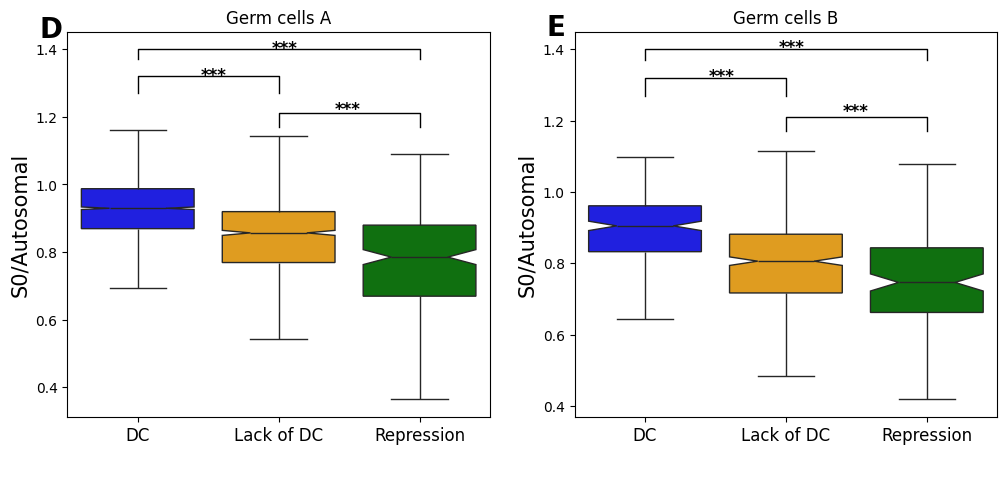

In [103]:
Inactivated_all=pd.read_csv("/nfs/scistore18/vicosgrp/melkrewi/Project_snRNA_ovaries_with_W/5.replicate_4/counts_region/zones_all_clusters_expression_19_06_2024.txt",sep="\t")
merged_with_cellbender=pd.merge(Inactivated_all,exp,on='barcodes')
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 5))
my_pal_2 ={'DC':'blue','Lack of DC':'orange','Repression':'green'}
plt.subplot(1,2,1)
sns.boxplot(x='zone_x', y='mean_all_rows', data=merged_with_cellbender[merged_with_cellbender['seurat_clusters']==1],showfliers=False,hue='zone_x',order=['DC','Lack of DC','Repression'],notch=True,palette=my_pal_2)
axes[0].set_ylabel('S0/Autosomal',fontsize=15)
axes[0].set_title('Germ cells A')
axes[0].set_xlabel(' ',fontsize=15)
axes[0].set_xticks([0,1,2],['DC','Lack of DC','Repression'],fontsize=12)
axes[0].text(-0.7, 1.5, 'D',fontsize=20, fontweight='bold', va='top')
plt.xlim(xmin=-0.5,xmax=2.5)
plt.plot([0,0, 2,2], [1.27+0.1, 1.3+0.1, 1.3+0.1,1.27+0.1], linewidth=1, color='k')
plt.plot([0,0, 1,1], [1.17+0.1, 1.22+0.1, 1.22+0.1,1.17+0.1], linewidth=1, color='k')
plt.plot([1,1, 2,2], [1.17, 1.21, 1.21,1.17], linewidth=1, color='k')
plt.text(0.95, 1.33+0.1, convert_pvalue_to_asterisks(ranksums(merged_with_cellbender[(merged_with_cellbender['seurat_clusters']==1)&(merged_with_cellbender['zone_x']=='Repression')]['mean_all_rows'],merged_with_cellbender[(merged_with_cellbender['seurat_clusters']==1)&(merged_with_cellbender['zone_x']=='DC')]['mean_all_rows'],alternative='less')[1]),fontsize=12, fontweight='bold', va='top')
plt.text(0.45, 1.25+0.1, convert_pvalue_to_asterisks(ranksums(merged_with_cellbender[(merged_with_cellbender['seurat_clusters']==1)&(merged_with_cellbender['zone_x']=='Lack of DC')]['mean_all_rows'],merged_with_cellbender[(merged_with_cellbender['seurat_clusters']==1)&(merged_with_cellbender['zone_x']=='DC')]['mean_all_rows'],alternative='less')[1]),fontsize=12, fontweight='bold', va='top')
plt.text(1.4, 1.25, convert_pvalue_to_asterisks(ranksums(merged_with_cellbender[(merged_with_cellbender['seurat_clusters']==1)&(merged_with_cellbender['zone_x']=='Repression')]['mean_all_rows'],merged_with_cellbender[(merged_with_cellbender['seurat_clusters']==1)&(merged_with_cellbender['zone_x']=='Lack of DC')]['mean_all_rows'],alternative='less')[1]),fontsize=12, fontweight='bold', va='top')
plt.subplot(1,2,2)
sns.boxplot(x='zone_x', y='mean_all_rows', data=merged_with_cellbender[merged_with_cellbender['seurat_clusters']==6],showfliers=False,hue='zone_x',order=['DC','Lack of DC','Repression'],notch=True,palette=my_pal_2)
axes[1].set_ylabel('S0/Autosomal',fontsize=15)
axes[1].set_title('Germ cells B')
axes[1].set_xticks([0,1,2],['DC','Lack of DC','Repression'],fontsize=12)
axes[1].set_xlabel(' ',fontsize=15)
plt.plot([0,0, 2,2], [1.27+0.1, 1.3+0.1, 1.3+0.1,1.27+0.1], linewidth=1, color='k')
plt.plot([0,0, 1,1], [1.17+0.1, 1.22+0.1, 1.22+0.1,1.17+0.1], linewidth=1, color='k')
plt.plot([1,1, 2,2], [1.17, 1.21, 1.21,1.17], linewidth=1, color='k')
axes[1].text(-0.7, 1.5, 'E',fontsize=20, fontweight='bold', va='top')
plt.xlim(xmin=-0.5,xmax=2.5)
plt.text(0.95, 1.33+0.1, convert_pvalue_to_asterisks(ranksums(merged_with_cellbender[(merged_with_cellbender['seurat_clusters']==6)&(merged_with_cellbender['zone_x']=='Repression')]['mean_all_rows'],merged_with_cellbender[(merged_with_cellbender['seurat_clusters']==6)&(merged_with_cellbender['zone_x']=='DC')]['mean_all_rows'],alternative='less')[1]),fontsize=12, fontweight='bold', va='top')
plt.text(0.45, 1.25+0.1, convert_pvalue_to_asterisks(ranksums(merged_with_cellbender[(merged_with_cellbender['seurat_clusters']==6)&(merged_with_cellbender['zone_x']=='Lack of DC')]['mean_all_rows'],merged_with_cellbender[(merged_with_cellbender['seurat_clusters']==6)&(merged_with_cellbender['zone_x']=='DC')]['mean_all_rows'],alternative='less')[1]),fontsize=12, fontweight='bold', va='top')
plt.text(1.4, 1.25, convert_pvalue_to_asterisks(ranksums(merged_with_cellbender[(merged_with_cellbender['seurat_clusters']==6)&(merged_with_cellbender['zone_x']=='Repression')]['mean_all_rows'],merged_with_cellbender[(merged_with_cellbender['seurat_clusters']==6)&(merged_with_cellbender['zone_x']=='Lack of DC')]['mean_all_rows'],alternative='less')[1]),fontsize=12, fontweight='bold', va='top')
plt.savefig('/nfs/scistore18/vicosgrp/melkrewi/Project_snRNA_ovaries_with_W/8.Jupyter_notebooks_for_submission/review_figures/No_ambient_validation_V1.png',bbox_inches='tight',facecolor='white')